In [83]:
# RSSI KNN

In [1]:
import os 
import sys

import sklearn as sk
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt 
import xgboost as xgb
from sklearn.preprocessing import OneHotEncoder

from scipy.stats import kurtosis, entropy
from scipy.fft import fft

In [2]:
sys.path.append(r"/media/mcs/1441ae67-d7cd-43e6-b028-169f78661a2f/kyle/csi_tool") #這行為絕對路徑，如需使用，必須要修改為當前決路徑
import csi_tool
import denoise

In [3]:
base_path = "/media/mcs/1441ae67-d7cd-43e6-b028-169f78661a2f/kyle/csi_tool/csi_dataset/RSSI/timestamp_allignment_Balanced_2024_12_14_rtt_logs.csv"

In [4]:
df = pd.read_csv(base_path)
df 

,timeStemp,Label,AP1_Distance (mm),AP2_Distance (mm),AP3_Distance (mm),AP4_Distance (mm),AP1_Rssi,AP2_Rssi,AP3_Rssi,AP4_Rssi,AP1_StdDev (mm),AP2_StdDev (mm),AP3_StdDev (mm),AP4_StdDev (mm)
0,493453295,1-11,718.0,8178.0,7432.0,4852.0,-60.0,-68.0,-61.0,-59.0,264.0,1502.0,325.0,934.0
1,493449532,1-11,639.0,8139.0,6930.0,4911.0,-62.0,-70.0,-59.0,-59.0,418.0,1466.0,799.0,485.0
2,493453815,1-11,678.0,8139.0,7471.0,4647.0,-61.0,-69.0,-62.0,-55.0,311.0,91.0,385.0,600.0
3,493452063,1-11,718.0,8022.0,7627.0,6219.0,-62.0,-69.0,-63.0,-55.0,324.0,1523.0,268.0,2649.0
4,493451194,1-11,561.0,8335.0,7471.0,4471.0,-61.0,-70.0,-62.0,-55.0,343.0,1195.0,312.0,1079.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19644,493967396,7-1,7280.0,4643.0,9678.0,1307.0,-64.0,-66.0,-61.0,-58.0,196.0,273.0,1174.0,230.0
19645,493961752,7-1,6309.0,2270.0,8503.0,844.0,-67.0,-75.0,-62.0,-59.0,125.0,174.0,1670.0,88.0
19646,493967789,7-1,6811.0,2475.0,9883.0,1375.0,-64.0,-66.0,-61.0,-57.0,377.0,918.0,822.0,188.0
19647,493968275,7-1,7837.0,2671.0,9511.0,897.0,-66.0,-65.0,-59.0,-58.0,594.0,1081.0,849.0,438.0


In [5]:
# Load data RSSI

label_to_coordinates_swapped = {
    "1-1":  (0, 0),   "1-2":  (0, 0.6),   "1-3":  (0, 1.2),   "1-4":  (0, 1.8),
    "1-5":  (0, 2.4), "1-6":  (0, 3.0),   "1-7":  (0, 3.6),   "1-8":  (0, 4.2),
    "1-9":  (0, 4.8), "1-10": (0, 5.4),   "1-11": (0, 6.0),

    "2-1":  (0.6, 0),  "2-11": (0.6, 6.0),

    "3-1":  (1.2, 0),  "3-11": (1.2, 6.0),

    "4-1":  (1.8, 0),  "4-11": (1.8, 6.0),

    "5-1":  (2.4, 0),  "5-11": (2.4, 6.0),

    "6-1":  (3.0, 0),  "6-2":  (3.0, 0.6),  "6-3":  (3.0, 1.2),  "6-4":  (3.0, 1.8),
    "6-5":  (3.0, 2.4), "6-6":  (3.0, 3.0),  "6-7":  (3.0, 3.6),  "6-8":  (3.0, 4.2),
    "6-9":  (3.0, 4.8), "6-10": (3.0, 5.4),  "6-11": (3.0, 6.0),

    "7-1":  (3.6, 0),  "7-11": (3.6, 6.0),

    "8-1":  (4.2, 0),  "8-11": (4.2, 6.0),

    "9-1":  (4.8, 0),  "9-11": (4.8, 6.0),

    "10-1": (5.4, 0),  "10-11": (5.4, 6.0),

    "11-1": (6.0, 0),  "11-2": (6.0, 0.6), "11-3": (6.0, 1.2), "11-4": (6.0, 1.8),
    "11-5": (6.0, 2.4),"11-6": (6.0, 3.0), "11-7": (6.0, 3.6), "11-8": (6.0, 4.2),
    "11-9": (6.0, 4.8),"11-10":(6.0, 5.4), "11-11":(6.0, 6.0)
}


coordinates = {
        1: (0, 0), 40: (0.6, 0), 39: (1.2, 0), 38: (1.8, 0), 37: (2.4, 0),
        36: (3.0, 0), 35: (3.6, 0), 34: (4.2, 0), 33: (4.8, 0), 32: (5.4, 0), 31: (6.0, 0),
        2: (0, 0.6), 3: (0, 1.2), 4: (0, 1.8), 5: (0, 2.4),
        6: (0, 3.0), 7: (0, 3.6), 8: (0, 4.2), 9: (0, 4.8), 10: (0, 5.4), 11: (0, 6.0),
        12: (0.6, 6.0), 13: (1.2, 6.0), 14: (1.8, 6.0), 15: (2.4, 6.0),
        16: (3.0, 6.0), 17: (3.6, 6.0), 18: (4.2, 6.0), 19: (4.8, 6.0),
        20: (5.4, 6.0), 21: (6.0, 6.0),
        22: (6.0, 5.4), 23: (6.0, 4.8), 24: (6.0, 4.2), 25: (6.0, 3.6),
        26: (6.0, 3.0), 27: (6.0, 2.4), 28: (6.0, 1.8), 29: (6.0, 1.2), 30: (6.0, 0.6),
        41: (3.0, 0.6), 42: (3.0, 1.2), 43: (3.0, 1.8),
        44: (3.0, 2.4), 45: (3.0, 3.0), 46: (3.0, 3.6),
        47: (3.0, 4.2), 48: (3.0, 4.8), 49: (3.0, 5.4)
    }
coordinate_to_label2 = {value: key for key, value in coordinates.items()}

# label_to_coordinates:  "1-1" -> (0, 0)
# coordinates:          1      -> (0, 0)

# 1) 先建立一個「座標 -> 數字」的反轉字典
coord_to_num = {value: key for key, value in coordinates.items()}
# coord_to_num[(0,0)] = 1,  coord_to_num[(0.6,0)] = 40, ...

# 2) 建立 "1-1" -> 整數標籤 的 map
label_str_to_num = {}
for str_label, coord in label_to_coordinates_swapped.items():
    if coord in coord_to_num:  # 確保在座標字典中找得到
        label_str_to_num[str_label] = coord_to_num[coord]

In [6]:
coordinate_to_label2

{(0, 0): 1,
 (0.6, 0): 40,
 (1.2, 0): 39,
 (1.8, 0): 38,
 (2.4, 0): 37,
 (3.0, 0): 36,
 (3.6, 0): 35,
 (4.2, 0): 34,
 (4.8, 0): 33,
 (5.4, 0): 32,
 (6.0, 0): 31,
 (0, 0.6): 2,
 (0, 1.2): 3,
 (0, 1.8): 4,
 (0, 2.4): 5,
 (0, 3.0): 6,
 (0, 3.6): 7,
 (0, 4.2): 8,
 (0, 4.8): 9,
 (0, 5.4): 10,
 (0, 6.0): 11,
 (0.6, 6.0): 12,
 (1.2, 6.0): 13,
 (1.8, 6.0): 14,
 (2.4, 6.0): 15,
 (3.0, 6.0): 16,
 (3.6, 6.0): 17,
 (4.2, 6.0): 18,
 (4.8, 6.0): 19,
 (5.4, 6.0): 20,
 (6.0, 6.0): 21,
 (6.0, 5.4): 22,
 (6.0, 4.8): 23,
 (6.0, 4.2): 24,
 (6.0, 3.6): 25,
 (6.0, 3.0): 26,
 (6.0, 2.4): 27,
 (6.0, 1.8): 28,
 (6.0, 1.2): 29,
 (6.0, 0.6): 30,
 (3.0, 0.6): 41,
 (3.0, 1.2): 42,
 (3.0, 1.8): 43,
 (3.0, 2.4): 44,
 (3.0, 3.0): 45,
 (3.0, 3.6): 46,
 (3.0, 4.2): 47,
 (3.0, 4.8): 48,
 (3.0, 5.4): 49}

In [7]:
df["Label"] = (
    df["Label"]
    .map(label_to_coordinates_swapped)   # 由 "1-1" → (0,0)
    .map(coordinate_to_label2)   # 由 (0,0) → 1 (或其他整數標籤)
)


In [8]:
data = df.drop(columns=['timeStemp', 'AP1_Distance (mm)', 'AP2_Distance (mm)', 'AP3_Distance (mm)', 'AP4_Distance (mm)', 'AP1_StdDev (mm)','AP2_StdDev (mm)', 'AP3_StdDev (mm)', 'AP4_StdDev (mm)'])

In [9]:
import pandas as pd

# 假設你的 RSSI DataFrame 名叫 df_rssi
# 它至少包含欄位 ["Label", "AP1_Rssi", "AP2_Rssi", ...] 等資訊

target_total = 500  # 每個 Label 期望擁有的筆數
need_extra = 99     # 需要再抽幾筆 (500 - 401 = 99)

all_label_groups = []  # 用來存放每個 label 擴充後的 DataFrame

unique_labels = data["Label"].unique()

for label_value in unique_labels:
    sub_df = data[data["Label"] == label_value].reset_index(drop=True)
    
    # 假設這裡已知 sub_df 長度就是 401；若有需要，你可加檢查:
    # if len(sub_df) != 401:
    #     print(f"Label {label_value} 不等於 401 筆，目前有 {len(sub_df)} 筆。")
    #     # 或視需求做別的處理

    # 從 sub_df 再抽樣 99 筆 (有放回 replace=True)
    extra = sub_df.sample(n=need_extra, replace=True)
    
    # 與原 sub_df 合併
    expanded_sub_df = pd.concat([sub_df, extra], ignore_index=True)
    
    # 此時 expanded_sub_df 就有 401 + 99 = 500 筆
    all_label_groups.append(expanded_sub_df)

# 最後將所有 label 擴充後的 DataFrame 合併
df_final = pd.concat(all_label_groups, ignore_index=True)

print(df_final.shape)  # 應該是 (500 * label_count, ...)
print(df_final["Label"].value_counts())  # 檢查每個 Label 筆數是否都 500


(24500, 5)
Label
11    500
10    500
9     500
8     500
7     500
6     500
5     500
4     500
3     500
2     500
1     500
40    500
39    500
38    500
37    500
36    500
41    500
42    500
43    500
44    500
45    500
46    500
47    500
48    500
49    500
16    500
15    500
14    500
13    500
12    500
17    500
18    500
19    500
20    500
21    500
22    500
23    500
24    500
25    500
26    500
27    500
28    500
29    500
30    500
31    500
32    500
33    500
34    500
35    500
Name: count, dtype: int64


In [10]:
df_final

,Label,AP1_Rssi,AP2_Rssi,AP3_Rssi,AP4_Rssi
0,11,-60.0,-68.0,-61.0,-59.0
1,11,-62.0,-70.0,-59.0,-59.0
2,11,-61.0,-69.0,-62.0,-55.0
3,11,-62.0,-69.0,-63.0,-55.0
4,11,-61.0,-70.0,-62.0,-55.0
...,...,...,...,...,...
24495,35,-65.0,-65.0,-61.0,-58.0
24496,35,-65.0,-64.0,-60.0,-58.0
24497,35,NaN,NaN,-61.0,-58.0
24498,35,-60.0,-64.0,-62.0,-59.0


In [101]:
df_final.shape[0]

24500

In [11]:
label = df_final['Label']
data = df_final.drop(columns=['Label'])

In [12]:
coor = label.map(label_to_coordinates_swapped)

In [13]:
rssi =data
label = np.array(label).astype(int)

In [14]:
label

array([11, 11, 11, ..., 35, 35, 35])

In [15]:
rssi

,AP1_Rssi,AP2_Rssi,AP3_Rssi,AP4_Rssi
0,-60.0,-68.0,-61.0,-59.0
1,-62.0,-70.0,-59.0,-59.0
2,-61.0,-69.0,-62.0,-55.0
3,-62.0,-69.0,-63.0,-55.0
4,-61.0,-70.0,-62.0,-55.0
...,...,...,...,...
24495,-65.0,-65.0,-61.0,-58.0
24496,-65.0,-64.0,-60.0,-58.0
24497,NaN,NaN,-61.0,-58.0
24498,-60.0,-64.0,-62.0,-59.0


In [16]:
encoder = OneHotEncoder(sparse_output=False)
one_hot_labels = encoder.fit_transform(np.array(label).reshape(-1, 1))

In [17]:
rssi = rssi.fillna(-120)

rssi3ap = rssi.iloc[:, :3]
rssi2ap = rssi.iloc[:, :2]
rssi1ap = rssi.iloc[:, :1]

In [18]:
rssi3ap

,AP1_Rssi,AP2_Rssi,AP3_Rssi
0,-60.0,-68.0,-61.0
1,-62.0,-70.0,-59.0
2,-61.0,-69.0,-62.0
3,-62.0,-69.0,-63.0
4,-61.0,-70.0,-62.0
...,...,...,...
24495,-65.0,-65.0,-61.0
24496,-65.0,-64.0,-60.0
24497,-120.0,-120.0,-61.0
24498,-60.0,-64.0,-62.0


In [19]:
amp_train, amp_temp, y_train, y_temp = train_test_split(rssi, one_hot_labels, test_size=1/3, random_state=42)
amp_val, amp_test, y_val, y_test = train_test_split(amp_temp, y_temp, test_size=1/3, random_state=42)

In [20]:
amp_train

,AP1_Rssi,AP2_Rssi,AP3_Rssi,AP4_Rssi
22767,-65.0,-57.0,-68.0,-60.0
15714,-58.0,-65.0,-53.0,-59.0
7997,-62.0,-65.0,-60.0,-57.0
18413,-65.0,-62.0,-50.0,-67.0
1002,-58.0,-73.0,-64.0,-50.0
...,...,...,...,...
21575,-67.0,-57.0,-57.0,-62.0
5390,-61.0,-73.0,-64.0,-55.0
860,-64.0,-73.0,-56.0,-64.0
15795,-52.0,-63.0,-53.0,-64.0


## 4AP

In [21]:
knn = KNeighborsClassifier(n_neighbors=3,metric='euclidean')


In [22]:
knn.fit(amp_train, y_train)

y_pred = knn.predict(amp_test)

In [23]:
y_pred = np.argmax(y_pred, axis=1)

In [24]:
accuracy_score(np.argmax(y_test, axis=1), y_pred)

0.8898273962541314

In [25]:
def compute_mean_distance_error(y_true, y_pred, coordinates):
    """
    y_true, y_pred: 一維的 NumPy 陣列，分別存放真實和預測的 label（整數）
    coordinates: dict, label -> (x, y)
    """
    errors = []
    for true_label, pred_label in zip(y_true, y_pred):
        # 取出對應的座標
        if true_label not in coordinates or pred_label not in coordinates:
            # 若某個 label 不在座標字典內，就跳過（或視需求處理）
            continue
        true_coord = np.array(coordinates[true_label])
        pred_coord = np.array(coordinates[pred_label])
        # 計算歐氏距離
        error = np.linalg.norm(pred_coord - true_coord)
        errors.append(error)
    return np.mean(errors) if errors else None

COORDINATES = {
    # 下邊界 (1-10 和 40-31)
    1: (0, 0), 40: (0.6, 0), 39: (1.2, 0), 38: (1.8, 0), 37: (2.4, 0),
    36: (3.0, 0), 35: (3.6, 0), 34: (4.2, 0), 33: (4.8, 0), 32: (5.4, 0), 31: (6.0, 0),

    # 左邊界 (1-11)
    2: (0, 0.6), 3: (0, 1.2), 4: (0, 1.8), 5: (0, 2.4),
    6: (0, 3.0), 7: (0, 3.6), 8: (0, 4.2), 9: (0, 4.8), 10: (0, 5.4), 11: (0, 6.0),

    # 上邊界 (11-21)
    12: (0.6, 6.0), 13: (1.2, 6.0), 14: (1.8, 6.0), 15: (2.4, 6.0),
    16: (3.0, 6.0), 17: (3.6, 6.0), 18: (4.2, 6.0), 19: (4.8, 6.0),
    20: (5.4, 6.0), 21: (6.0, 6.0),

    # 右邊界 (21-31)
    22: (6.0, 5.4), 23: (6.0, 4.8), 24: (6.0, 4.2), 25: (6.0, 3.6),
    26: (6.0, 3.0), 27: (6.0, 2.4), 28: (6.0, 1.8), 29: (6.0, 1.2), 30: (6.0, 0.6),

    # 中間點 (41-49)
    41: (3.0, 0.6), 42: (3.0, 1.2), 43: (3.0, 1.8),
    44: (3.0, 2.4), 45: (3.0, 3.0), 46: (3.0, 3.6),
    47: (3.0, 4.2), 48: (3.0, 4.8), 49: (3.0, 5.4)
}

mean_error = compute_mean_distance_error(np.argmax(y_test, axis=1), y_pred, COORDINATES)
print("Mean distance error:", mean_error)

Mean distance error: 0.22841381301244937


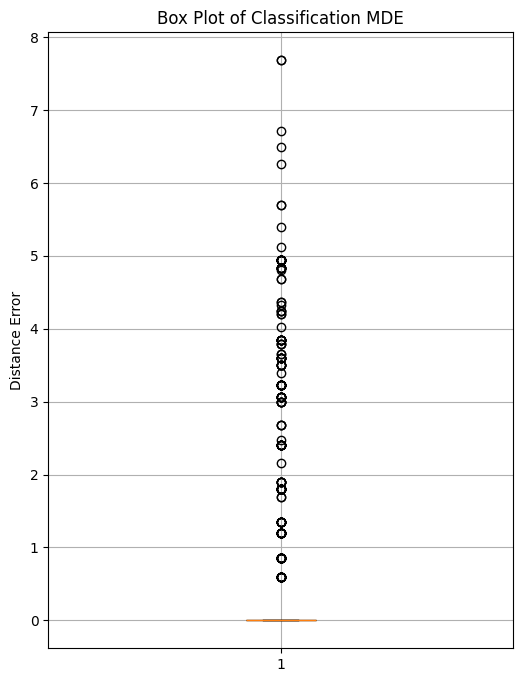

In [26]:
import numpy as np
import matplotlib.pyplot as plt

# 計算每筆資料的距離誤差

def compute_individual_errors_cls(y_true, y_pred, coordinates):
    """
    y_true, y_pred: 一維的 NumPy 陣列，分別存放真實和預測的 label（整數）
    coordinates: dict, label -> (x, y)
    """
    errors = []
    for true_label, pred_label in zip(y_true, y_pred):
        # 若某個標籤不在字典中，就跳過
        if true_label not in coordinates or pred_label not in coordinates:
            continue
        true_coord = np.array(coordinates[true_label])
        pred_coord = np.array(coordinates[pred_label])
        error = np.linalg.norm(pred_coord - true_coord)
        errors.append(error)
    return np.array(errors)
errors = compute_individual_errors_cls(np.argmax(y_test, axis=1), y_pred, COORDINATES)

# 繪製箱型圖
plt.figure(figsize=(6, 8))
plt.boxplot(errors, vert=True, patch_artist=True, boxprops=dict(facecolor="skyblue"))
plt.ylabel("Distance Error")
plt.title("Box Plot of Classification MDE")
plt.grid(True)

plt.show()

#3AP

In [27]:
amp_train, amp_temp, y_train, y_temp = train_test_split(rssi3ap, one_hot_labels, test_size=1/3, random_state=42)
amp_val, amp_test, y_val, y_test = train_test_split(amp_temp, y_temp, test_size=1/3, random_state=42)

In [28]:
knn = KNeighborsClassifier(n_neighbors=3,metric='euclidean')
knn.fit(amp_train, y_train)

y_pred = knn.predict(amp_test)

accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))

0.8332721263312522

In [29]:
mean_error = compute_mean_distance_error(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), COORDINATES)
print("Mean distance error:", mean_error)

Mean distance error: 0.3620706915607759


#2AP

In [30]:
amp_train, amp_temp, y_train, y_temp = train_test_split(rssi2ap, one_hot_labels, test_size=1/3, random_state=42)
amp_val, amp_test, y_val, y_test = train_test_split(amp_temp, y_temp, test_size=1/3, random_state=42)

In [31]:
knn = KNeighborsClassifier(n_neighbors=3,metric='euclidean')
knn.fit(amp_train, y_train)

y_pred = knn.predict(amp_test)

accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))

0.5508630187293426

In [32]:
mean_error = compute_mean_distance_error(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), COORDINATES)
print("Mean distance error:", mean_error)

Mean distance error: 1.2317960896559044


#1AP

In [147]:
amp_train, amp_temp, y_train, y_temp = train_test_split(rssi1ap, one_hot_labels, test_size=1/3, random_state=42)
amp_val, amp_test, y_val, y_test = train_test_split(amp_temp, y_temp, test_size=1/3, random_state=42)

In [148]:
knn = KNeighborsClassifier(n_neighbors=3,metric='euclidean')
knn.fit(amp_train, y_train)

y_pred = knn.predict(amp_test)

accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))

0.0763863385971355

In [149]:
mean_error = compute_mean_distance_error(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), COORDINATES)
print("Mean distance error:", mean_error)

Mean distance error: 1.8877758671276341


In [58]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
import numpy as np

# 設定 N-Fold 交叉驗證
N_FOLD = 5  # 設定 N 為 10
skf = StratifiedKFold(n_splits=N_FOLD, shuffle=True, random_state=1)

accuracies = []  # 儲存每次 Fold 的準確率

# 轉換 one-hot 標籤為標籤索引
y_labels = np.argmax(one_hot_labels, axis=1)  # 轉換成 (N,)

# 開始 N-Fold 交叉驗證
for train_index, test_index in skf.split(rssi, y_labels):  # ✅ 使用標籤索引
    X_train, X_test = rssi.iloc[train_index],rssi.iloc[test_index]
    y_train, y_test = y_labels[train_index], y_labels[test_index]  # ✅ 確保 y_train, y_test 是 (N,)

    # 訓練 KNN 模型
    knn.fit(X_train, y_train)

    # 進行預測
    y_pred = knn.predict(X_test)

    # 計算準確率
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)

    print(f"Fold 準確率: {acc:.4f}")

# 計算 N-Fold 平均準確率與標準差
mean_acc = np.mean(accuracies)
std_acc = np.std(accuracies)

print("\n📊 N-FOLD 交叉驗證結果")
print(f"⏱️ 平均準確率: {mean_acc * 100:.2f}%")
print(f"📉 準確率標準差: {std_acc * 100:.2f}%")


/home/mcs/anaconda3/envs/kyle_ai/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


Fold 準確率: 0.9376
Fold 準確率: 0.9306
Fold 準確率: 0.9386
Fold 準確率: 0.9363
Fold 準確率: 0.9422

📊 N-FOLD 交叉驗證結果
⏱️ 平均準確率: 93.71%
📉 準確率標準差: 0.38%


In [36]:
knn = KNeighborsClassifier(n_neighbors=3, weights='distance', metric='manhattan')

In [37]:
import time
import numpy as np


total_times = []  # 儲存 N 次的總推論時間
sample_times = []  # 儲存 N 次的單筆推論時間
knn.fit(amp_train, y_train)
start_time = time.perf_counter()
y_pred = knn.predict(amp_test)  # 進行 KNN 預測
end_time = time.perf_counter()

total_time = end_time - start_time  # 計算 KNN 預測總時間
print(f"總推論時間: {total_time:.6f} 秒")
total_times.append(total_time)

avg_time_per_sample = total_time / len(amp_test)  # 計算每筆資料的平均推論時間
sample_times.append(avg_time_per_sample)

# 計算統計數據
mean_total_time = np.mean(total_times)
mean_sample_time = np.mean(sample_times)
std_sample_time = np.std(sample_times)

# 顯示結果
print(f"📊 N-FOLD 測試結果（共 {N_FOLD} 次）")
print(f"⏳ 平均每次總推論時間: {mean_total_time:.6f} 秒")
print(f"⏱️ 平均每筆資料推論時間: {mean_sample_time * 1000:.6f} 毫秒")
print(f"📉 單筆推論時間標準差: {std_sample_time * 1000:.6f} 毫秒")






KeyboardInterrupt



In [117]:
y_pred = np.argmax(y_pred, axis=1)

print(y_pred)

[19  0 26 ...  0 14 14]


Mean distance error: 0.01992725233184797


## 3AP

In [122]:
skf = StratifiedKFold(n_splits=N_FOLD, shuffle=True, random_state=42)

accuracies = []  # 儲存每次 Fold 的準確率

# 轉換 one-hot 標籤為標籤索引
y_labels = np.argmax(one_hot_labels, axis=1)  # 轉換成 (N,)

# 開始 N-Fold 交叉驗證
for train_index, test_index in skf.split(rssi3ap, y_labels):  # ✅ 使用標籤索引
    X_train, X_test = rssi3ap.iloc[train_index],rssi3ap.iloc[test_index]
    y_train, y_test = y_labels[train_index], y_labels[test_index]  # ✅ 確保 y_train, y_test 是 (N,)

    # 訓練 KNN 模型
    knn.fit(X_train, y_train)

    # 進行預測
    y_pred = knn.predict(X_test)

    # 計算準確率
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)

    print(f"Fold 準確率: {acc:.4f}")

# 計算 N-Fold 平均準確率與標準差
mean_acc = np.mean(accuracies)
std_acc = np.std(accuracies)

print("\n📊 N-FOLD 交叉驗證結果")
print(f"⏱️ 平均準確率: {mean_acc * 100:.2f}%")
print(f"📉 準確率標準差: {std_acc * 100:.2f}%")

Fold 準確率: 0.4518
Fold 準確率: 0.4490
Fold 準確率: 0.4431
Fold 準確率: 0.4445
Fold 準確率: 0.4537

📊 N-FOLD 交叉驗證結果
⏱️ 平均準確率: 44.84%
📉 準確率標準差: 0.41%


In [32]:
skf = StratifiedKFold(n_splits=N_FOLD, shuffle=True, random_state=42)

accuracies = []  # 儲存每次 Fold 的準確率

# 轉換 one-hot 標籤為標籤索引
y_labels = np.argmax(one_hot_labels, axis=1)  # 轉換成 (N,)

# 開始 N-Fold 交叉驗證
for train_index, test_index in skf.split(rssi2ap, y_labels):  # ✅ 使用標籤索引
    X_train, X_test = rssi2ap.iloc[train_index],rssi2ap.iloc[test_index]
    y_train, y_test = y_labels[train_index], y_labels[test_index]  # ✅ 確保 y_train, y_test 是 (N,)

    # 訓練 KNN 模型
    knn.fit(X_train, y_train)

    # 進行預測
    y_pred = knn.predict(X_test)

    # 計算準確率
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)

    print(f"Fold 準確率: {acc:.4f}")

# 計算 N-Fold 平均準確率與標準差
mean_acc = np.mean(accuracies)
std_acc = np.std(accuracies)

print("\n📊 N-FOLD 交叉驗證結果")
print(f"⏱️ 平均準確率: {mean_acc * 100:.2f}%")
print(f"📉 準確率標準差: {std_acc * 100:.2f}%")

Fold 準確率: 0.1972
Fold 準確率: 0.2064
Fold 準確率: 0.2061
Fold 準確率: 0.2198
Fold 準確率: 0.1995

📊 N-FOLD 交叉驗證結果
⏱️ 平均準確率: 20.58%
📉 準確率標準差: 0.79%


/home/mcs/anaconda3/envs/kyle_ai/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


In [33]:
skf = StratifiedKFold(n_splits=N_FOLD, shuffle=True, random_state=42)

accuracies = []  # 儲存每次 Fold 的準確率

# 轉換 one-hot 標籤為標籤索引
y_labels = np.argmax(one_hot_labels, axis=1)  # 轉換成 (N,)

# 開始 N-Fold 交叉驗證
for train_index, test_index in skf.split(rssi1ap, y_labels):  # ✅ 使用標籤索引
    X_train, X_test = rssi1ap.iloc[train_index],rssi1ap.iloc[test_index]
    y_train, y_test = y_labels[train_index], y_labels[test_index]  # ✅ 確保 y_train, y_test 是 (N,)

    # 訓練 KNN 模型
    knn.fit(X_train, y_train)

    # 進行預測
    y_pred = knn.predict(X_test)

    # 計算準確率
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)

    print(f"Fold 準確率: {acc:.4f}")

# 計算 N-Fold 平均準確率與標準差
mean_acc = np.mean(accuracies)
std_acc = np.std(accuracies)

print("\n📊 N-FOLD 交叉驗證結果")
print(f"⏱️ 平均準確率: {mean_acc * 100:.2f}%")
print(f"📉 準確率標準差: {std_acc * 100:.2f}%")

Fold 準確率: 0.0746
Fold 準確率: 0.0845
Fold 準確率: 0.0659
Fold 準確率: 0.0710
Fold 準確率: 0.0939

📊 N-FOLD 交叉驗證結果
⏱️ 平均準確率: 7.80%
📉 準確率標準差: 1.00%


/home/mcs/anaconda3/envs/kyle_ai/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


# Regression

In [53]:
coor_array = np.array(coor)
coor_list =[]
for i in range(coor_array.shape[0]):
    coor_list.append([coor_array[i][0], coor_array[i][1]]) 
    


(19649, 2)
Fold 1 mean distance: 0.3845
Fold 2 mean distance: 0.3746
Fold 3 mean distance: 0.3913
Fold 4 mean distance: 0.3903
Fold 5 mean distance: 0.3650

📊 5-Fold結果
Average distance across folds: 0.3811
Std of distance across folds:   0.0100


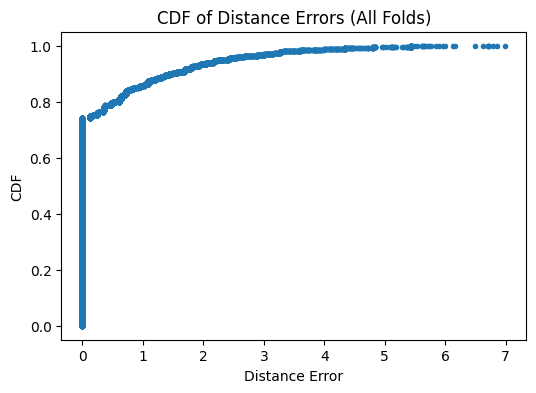

In [62]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt

kf = KFold(n_splits=5, shuffle=True, random_state=1)
model = KNeighborsRegressor(n_neighbors=5)

distances_per_fold = []
all_distances = []  # <-- 儲存所有測試樣本的誤差

coor_array = np.array(coor_list)  # (N, 2)
print(coor_array.shape)  # 應該是 (N, 2)

for fold_id, (train_idx, test_idx) in enumerate(kf.split(rssi, coor_array), start=1):
    X_train, X_test = rssi.iloc[train_idx], rssi.iloc[test_idx]
    Y_train, Y_test = coor_array[train_idx], coor_array[test_idx]

    # 訓練
    model.fit(X_train, Y_train)

    # 預測
    Y_pred = model.predict(X_test)  # shape (M, 2)

    # 計算每筆樣本歐幾里得距離
    distances = np.linalg.norm(Y_test - Y_pred, axis=1)  # shape (M,)
    all_distances.extend(distances)  # 把本 fold 的所有距離加入總列表

    # 取平均並存到 distances_per_fold
    mean_dist = np.mean(distances)
    distances_per_fold.append(mean_dist)

    print(f"Fold {fold_id} mean distance: {mean_dist:.4f}")

# 統計 5-Fold 的平均與標準差
fold_mean = np.mean(distances_per_fold)
fold_std  = np.std(distances_per_fold)

print("\n📊 5-Fold結果")
print(f"Average distance across folds: {fold_mean:.4f}")
print(f"Std of distance across folds:   {fold_std:.4f}")

# --------------------------------------------------------------------
# 2. 繪製所有測試樣本的誤差 CDF
# --------------------------------------------------------------------
all_distances = np.array(all_distances)  # 轉成 NumPy array
# 依照數值由小到大排序
sorted_distances = np.sort(all_distances)
N = len(sorted_distances)

# CDF：第 i 個樣本 (排序後) 對應的累積機率 i / N
cdf_values = np.arange(1, N + 1) / N

plt.figure(figsize=(6, 4))
plt.plot(sorted_distances, cdf_values, marker='.', linestyle='none')
plt.xlabel('Distance Error')
plt.ylabel('CDF')
plt.title('CDF of Distance Errors (All Folds)')
plt.show()


(19649, 2)
Fold 1 mean distance: 0.7966
Fold 2 mean distance: 0.7937
Fold 3 mean distance: 0.7653
Fold 4 mean distance: 0.8260
Fold 5 mean distance: 0.8109

📊 5-Fold結果
Average distance across folds: 0.7985
Std of distance across folds:   0.0202


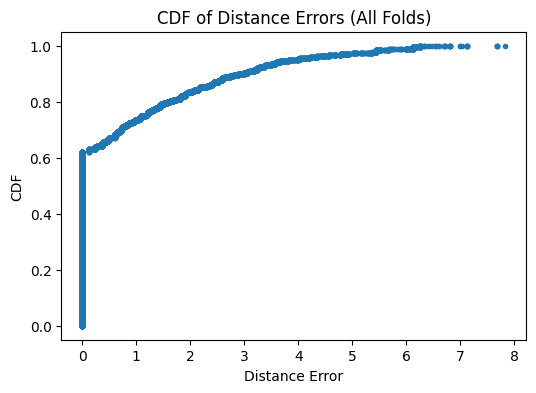

In [64]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt

kf = KFold(n_splits=5, shuffle=True, random_state=1)
model = KNeighborsRegressor(n_neighbors=5)

distances_per_fold = []
all_distances = []  # <-- 儲存所有測試樣本的誤差

coor_array = np.array(coor_list)  # (N, 2)
print(coor_array.shape)  # 應該是 (N, 2)

for fold_id, (train_idx, test_idx) in enumerate(kf.split(rssi3ap, coor_array), start=1):
    X_train, X_test = rssi3ap.iloc[train_idx], rssi3ap.iloc[test_idx]
    Y_train, Y_test = coor_array[train_idx], coor_array[test_idx]

    # 訓練
    model.fit(X_train, Y_train)

    # 預測
    Y_pred = model.predict(X_test)  # shape (M, 2)

    # 計算每筆樣本歐幾里得距離
    distances = np.linalg.norm(Y_test - Y_pred, axis=1)  # shape (M,)
    all_distances.extend(distances)  # 把本 fold 的所有距離加入總列表

    # 取平均並存到 distances_per_fold
    mean_dist = np.mean(distances)
    distances_per_fold.append(mean_dist)

    print(f"Fold {fold_id} mean distance: {mean_dist:.4f}")

# 統計 5-Fold 的平均與標準差
fold_mean = np.mean(distances_per_fold)
fold_std  = np.std(distances_per_fold)

print("\n📊 5-Fold結果")
print(f"Average distance across folds: {fold_mean:.4f}")
print(f"Std of distance across folds:   {fold_std:.4f}")

# --------------------------------------------------------------------
# 2. 繪製所有測試樣本的誤差 CDF
# --------------------------------------------------------------------
all_distances = np.array(all_distances)  # 轉成 NumPy array
# 依照數值由小到大排序
sorted_distances = np.sort(all_distances)
N = len(sorted_distances)

# CDF：第 i 個樣本 (排序後) 對應的累積機率 i / N
cdf_values = np.arange(1, N + 1) / N

plt.figure(figsize=(6, 4))
plt.plot(sorted_distances, cdf_values, marker='.', linestyle='none')
plt.xlabel('Distance Error')
plt.ylabel('CDF')
plt.title('CDF of Distance Errors (All Folds)')
plt.show()

In [65]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

# (1) 建立資料: X.shape = (N, d)，Y.shape = (N, 2)
#     例如 Y 就是 (x, y) 的真實位置。
# (2) 建立 K-Fold
kf = KFold(n_splits=5, shuffle=True, random_state=1)

model = KNeighborsRegressor(n_neighbors=5)  # KNN 迴歸為例

distances_per_fold = []  # 這裡存「平均歐幾里得距離」結果

coor_array = np.array(coor_list)  # 轉成 ndarray
# 檢查 shape
print(coor_array.shape)  # 應該要 (N, 2)

for train_idx, test_idx in kf.split(rssi2ap,coor_array):
    X_train, X_test = rssi2ap.iloc[train_idx], rssi2ap.iloc[test_idx]
    Y_train, Y_test = coor_array[train_idx],coor_array[test_idx]  # Y 是 (N, 2)

    # (3) 訓練模型
    model.fit(X_train, Y_train)

    # (4) 預測
    Y_pred = model.predict(X_test)  # shape (M, 2)

    # (5) 計算「每筆樣本」的歐幾里得距離 => 取平均
    distances = np.linalg.norm(Y_test - Y_pred, axis=1)
    mean_dist = np.mean(distances)
    distances_per_fold.append(mean_dist)

    print(f"Fold mean distance: {mean_dist:.4f}")

# 計算5折平均
fold_mean = np.mean(distances_per_fold)
fold_std  = np.std(distances_per_fold)
print("\n📊 5-Fold結果")
print(f"Average distance across folds: {fold_mean:.4f}")
print(f"Std of distance across folds:   {fold_std:.4f}")

(19649, 2)
Fold mean distance: 2.0881
Fold mean distance: 2.1564
Fold mean distance: 2.1476
Fold mean distance: 2.1479
Fold mean distance: 2.1099

📊 5-Fold結果
Average distance across folds: 2.1300
Std of distance across folds:   0.0264
